In [26]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import ollama

In [27]:
system_prompt = '''
You are a very advance classification model for e-commerce products.
You take a description as an input, and return one of the following category for the product:
["Computer","Home Furnishing","Baby Care","Watches","Home Decor & Festive Needs","Kitchen & Dining","Beauty and Personal Care "]

Please return the category that fit the most to the description
'''


In [ ]:
#ollama.create(model='example', from_='mistral', system=system_prompt)

ProgressResponse(status='success', completed=None, total=None, digest=None)

In [39]:
from skollama.models.ollama.classification.zero_shot import ZeroShotOllamaClassifier

model = ZeroShotOllamaClassifier(model='mistral')

In [29]:
df = pd.read_csv("flipkart\\flipkart_com-ecommerce_sample_1050.csv")
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [30]:
df["main_category"] = df['product_category_tree'].str.split(" >> ").str[0].str.replace('["', '')
df['main_category'].value_counts()

main_category
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64

In [31]:
df['name_description'] = df['product_name'] + ' ' + df['description']

In [32]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

cat_dict = {key:value for value, key in enumerate(df['main_category'].unique())}

y_list = [cat_dict[cat] for cat in df['main_category']]

y = to_categorical(y_list, num_classes=7)


X_train, X_test, y_train, y_test = train_test_split(df['name_description'], y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.25,
                                                  random_state=42,
                                                  stratify=y_train)

In [40]:
model.fit(None, df['main_category'])

ZeroShotOllamaClassifier(model='mistral')

In [41]:
y_pred = model.predict(X_test)

100%|██████████| 210/210 [10:43<00:00,  3.06s/it]


In [45]:
reverse_dic = {value: key for key, value in cat_dict.items()}

y_test = [np.argmax(y) for y in y_test]
y_test = [reverse_dic[cat] for cat in y_test]

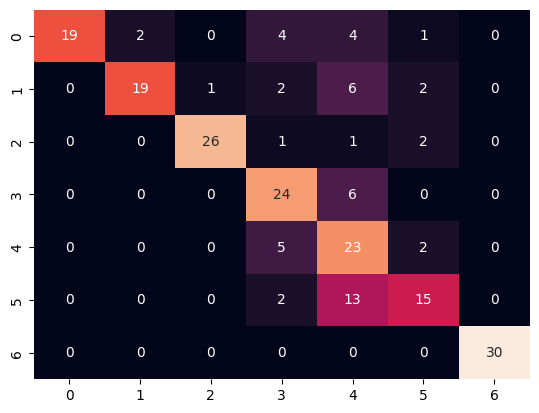

In [46]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_mat, annot=True, cbar=None);

In [48]:
round(accuracy_score(y_test,y_pred),3)

0.743

# 2.1 Few-Shot Learning (Small Dataset)

In [61]:

X_train, X_test, y_train, y_test = train_test_split(df['name_description'], df['main_category'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df['main_category'])

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.25,
                                                  random_state=42,
                                                  stratify=y_train)

In [62]:
from skollama.models.ollama.classification.few_shot import FewShotOllamaClassifier


few_shot_model = FewShotOllamaClassifier(model='mistral')

few_shot_model.fit(X_train[:49], y_train[:49])

FewShotOllamaClassifier(model='mistral')

In [63]:
y_pred = model.predict(X_test)

100%|██████████| 210/210 [10:33<00:00,  3.02s/it]


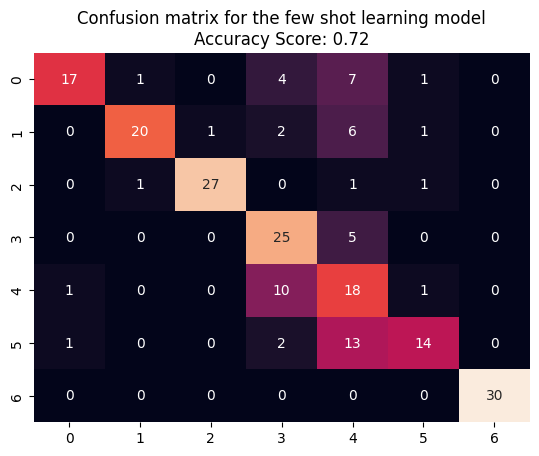

In [64]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)


sns.heatmap(conf_mat, annot=True, cbar=None)
plt.title(f"Confusion matrix for the few shot learning model\nAccuracy Score: {accuracy:.2f}");

# 2.2 Few-Shot Learning (Large Dataset)

In [65]:
from skollama.models.ollama.classification.few_shot import FewShotOllamaClassifier


few_shot_model = FewShotOllamaClassifier(model='mistral')

few_shot_model.fit(X_train, y_train)

FewShotOllamaClassifier(model='mistral')

In [66]:
y_pred = model.predict(X_test)

100%|██████████| 210/210 [10:56<00:00,  3.13s/it]


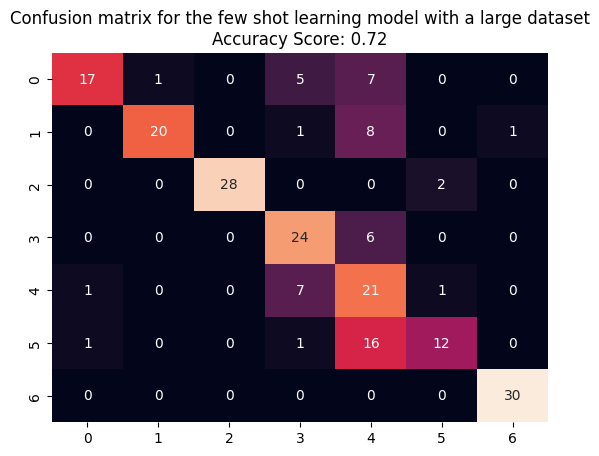

In [67]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)


sns.heatmap(conf_mat, annot=True, cbar=None)
plt.title(f"Confusion matrix for the few shot learning model with a large dataset\nAccuracy Score: {accuracy:.2f}");